<a href="https://colab.research.google.com/github/zayo1511/ProyectoLabAnaDatFinDisInd/blob/main/Proyecto_Laboratorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Paqueterías

In [1]:
!pip install semopy -q --disable-pip-version-check > /dev/null 2>&1

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
#from auto_ts import auto_timeseries
import statsmodels.api as sm
from semopy import Model, Optimizer, semplot

from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/Colab Notebooks/Laboratorio de analisis de datos financieros y de diseño de indicadores/Proyecto/'

from sklearn import set_config
set_config(working_memory=1024)

Mounted at /content/drive


## Contexto

Glass Restaurant es un restaurante estadounidense caracterizado por su amplia carta que tiene para presentar a los comensales. La carta esta dividida en 5 cocinas (Italiana, Mexicana, India, China y Americana). Al final de la visita, se les pide a los comensales que se les entrego la cuenta que escaneen el QR para poder dar una calificación del 1 al 5 a los siguientes rubros:

* Servicio : Como fue el servicio que se le ofreció al cliente.
* Comida : Que tal le parecio la comida que degutso ese día.
* Ambiente: Cómo estuvo el ambiente del restaurante en cuanto a la musica, los otros comensales y en general la experiencia en cuanto al lugar por la visita.

Por último el restaurante suma los 3 rating, para después sacar el promedio y ponerlo como un Rating general por la última compra que hizo.

## Objetivo

El restaurante se dió cuenta que la última vez que sacaron los ratings de los clientes que tenían, vieron que eran más los ratings bajos que los altos incrementando su miedo de que esto afecte a las ventas del lugar.

Su objetivo es mejorar la satisfacción y experiencia general del cliente para  poder incrementar las ventas del restaurante.

## Datos

In [5]:
df=pd.read_csv(data_path + 'satisfaction.csv')
df

,CustomerID,Age,Gender,Income,VisitFrequency,AverageSpend,PreferredCuisine,TimeOfVisit,GroupSize,DiningOccasion,MealType,WaitTime,ServiceRating,FoodRating,AmbianceRating,HighSatisfaction,Rating
0,654,35,Male,83380,Weekly,27.829142,Chinese,Breakfast,3,Business,Takeaway,43.523929,2,5,4,0,3.67
1,655,19,Male,43623,Rarely,115.408622,American,Dinner,1,Casual,Dine-in,57.524294,5,5,3,0,4.33
2,656,41,Female,83737,Weekly,106.693771,American,Dinner,6,Celebration,Dine-in,48.682623,3,4,5,0,4.00
3,657,43,Male,96768,Rarely,43.508508,Indian,Lunch,1,Celebration,Dine-in,7.552993,4,5,1,0,3.33
4,658,55,Female,67937,Monthly,148.084627,Chinese,Breakfast,1,Business,Takeaway,37.789041,2,3,5,0,3.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2149,39,Male,114857,Monthly,63.015254,American,Lunch,2,Business,Dine-in,7.206275,1,2,1,0,1.33
1496,2150,37,Female,133506,Weekly,190.991911,Italian,Lunch,4,Casual,Takeaway,37.863952,5,2,2,0,3.00
1497,2151,46,Male,119159,Monthly,150.088605,American,Lunch,4,Casual,Dine-in,3.925785,3,3,3,1,3.00
1498,2152,24,Male,27970,Weekly,196.363626,Italian,Dinner,6,Casual,Dine-in,24.228038,2,2,4,1,2.67


## KPI

Debido a que el objetivo es mejorar la satisfacción y experiencia del cliente, decidimos que el KPI necesario será el NPS, el cual nos ayudará a ver que tantas personas estan conformes y satisfechas con los productos y servicios de la empresa, además, de tomar en cuenta la satisfacción global del cliente. La variable que utilizaremos para poder medir este KPI será la variable de "Rating", la cual es calculada con base en el promedio de las 3 categorías de las que tenemos información: 'ServiceRating', 'FoodRating' y 'AmbianceRating'. Con base en el rating global se discrimina a los clientes clasificándolos en categorias de promotores, pasivos y detractores para poder contabilizar cuantos existen en cada grupo y obtener el valor del NPS.

### Calcular NPS

In [6]:
def PromDet(rating):
    if rating > 4.01:
        return 'Promotor'
    elif rating > 3.01:
        return 'Pasivo'
    else:
        return 'Detractor'


In [7]:
df['Pro/Det'] = df['AmbianceRating'].apply(PromDet)
df

,CustomerID,Age,Gender,Income,VisitFrequency,AverageSpend,PreferredCuisine,TimeOfVisit,GroupSize,DiningOccasion,MealType,WaitTime,ServiceRating,FoodRating,AmbianceRating,HighSatisfaction,Rating,Pro/Det
0,654,35,Male,83380,Weekly,27.829142,Chinese,Breakfast,3,Business,Takeaway,43.523929,2,5,4,0,3.67,Pasivo
1,655,19,Male,43623,Rarely,115.408622,American,Dinner,1,Casual,Dine-in,57.524294,5,5,3,0,4.33,Detractor
2,656,41,Female,83737,Weekly,106.693771,American,Dinner,6,Celebration,Dine-in,48.682623,3,4,5,0,4.00,Promotor
3,657,43,Male,96768,Rarely,43.508508,Indian,Lunch,1,Celebration,Dine-in,7.552993,4,5,1,0,3.33,Detractor
4,658,55,Female,67937,Monthly,148.084627,Chinese,Breakfast,1,Business,Takeaway,37.789041,2,3,5,0,3.33,Promotor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2149,39,Male,114857,Monthly,63.015254,American,Lunch,2,Business,Dine-in,7.206275,1,2,1,0,1.33,Detractor
1496,2150,37,Female,133506,Weekly,190.991911,Italian,Lunch,4,Casual,Takeaway,37.863952,5,2,2,0,3.00,Detractor
1497,2151,46,Male,119159,Monthly,150.088605,American,Lunch,4,Casual,Dine-in,3.925785,3,3,3,1,3.00,Detractor
1498,2152,24,Male,27970,Weekly,196.363626,Italian,Dinner,6,Casual,Dine-in,24.228038,2,2,4,1,2.67,Pasivo


In [8]:
ProDet = df['Pro/Det'].value_counts()
df_ProDet = pd.DataFrame(ProDet)
df_ProDet

,count
Pro/Det,
Detractor,890
Promotor,317
Pasivo,293


In [9]:
## NPS
NPS = ((317-890)/1500) *100
NPS

-38.2

### ¿Bueno o Malo?


El hecho que el NPS de la empresa sea negativo significa que es algo muy malo, ya que según el mercado el benchmark para el NPS por restaurante es de 42 para que este sea aceptable..El objetivo de la empresa es aumentar la satisfacción de los clientes, obteniendo un mayor número de promotores para hacer crecer su reconocimineto. Claramente mietras más alto pueda ser su NPS, mejor, no obstante el objetivo más proximo es el de convertir esta calificación a valores positivos.

Fuente Benchamark: https://customergauge.com/benchmarks/industry/consumer_brands/restaurants

## Visualización con variables

### Gender

#### Gráfica

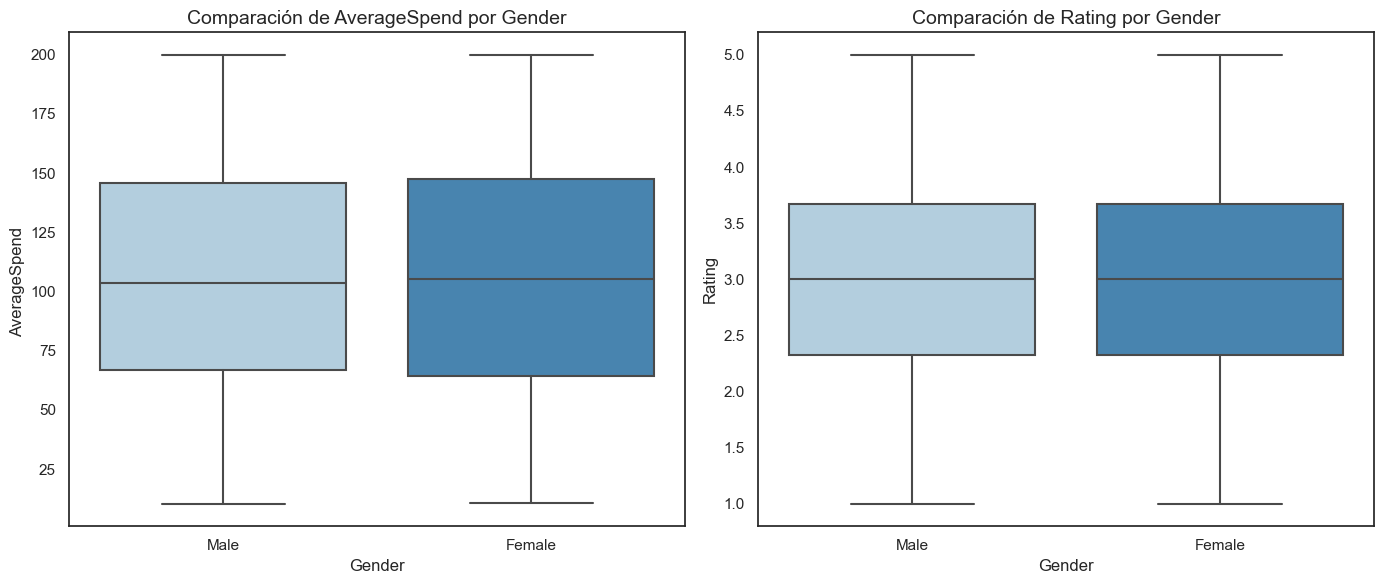

In [ ]:
plt.figure(figsize=(14, 6))

# Primera gráfica
plt.subplot(1, 2, 1)
sns.boxplot(x='Gender', y='AverageSpend', data=df, palette='Blues')
plt.title('Comparación de AverageSpend por Gender', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('AverageSpend ', fontsize=12)

# Segunda gráfica:
plt.subplot(1, 2, 2)
sns.boxplot(x='Gender', y='Rating', data=df, palette='Blues')
plt.title('Comparación de Rating por Gender', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Rating', fontsize=12)

plt.tight_layout()
plt.show()

### Age

#### Intervalos

In [ ]:
# Volver a generar los rangos y etiquetas personalizadas
intervalos = pd.qcut(df['Age'], q=4)  # Crear intervalos nuevamente
nuevas_etiquetas = [f"{int(interval.left)}-{int(interval.right)}" for interval in intervalos.cat.categories]

# Reasignar las etiquetas directamente al DataFrame
df['AgeGroup'] = pd.qcut(df['Age'], q=4, labels=nuevas_etiquetas)


#### Gráfica

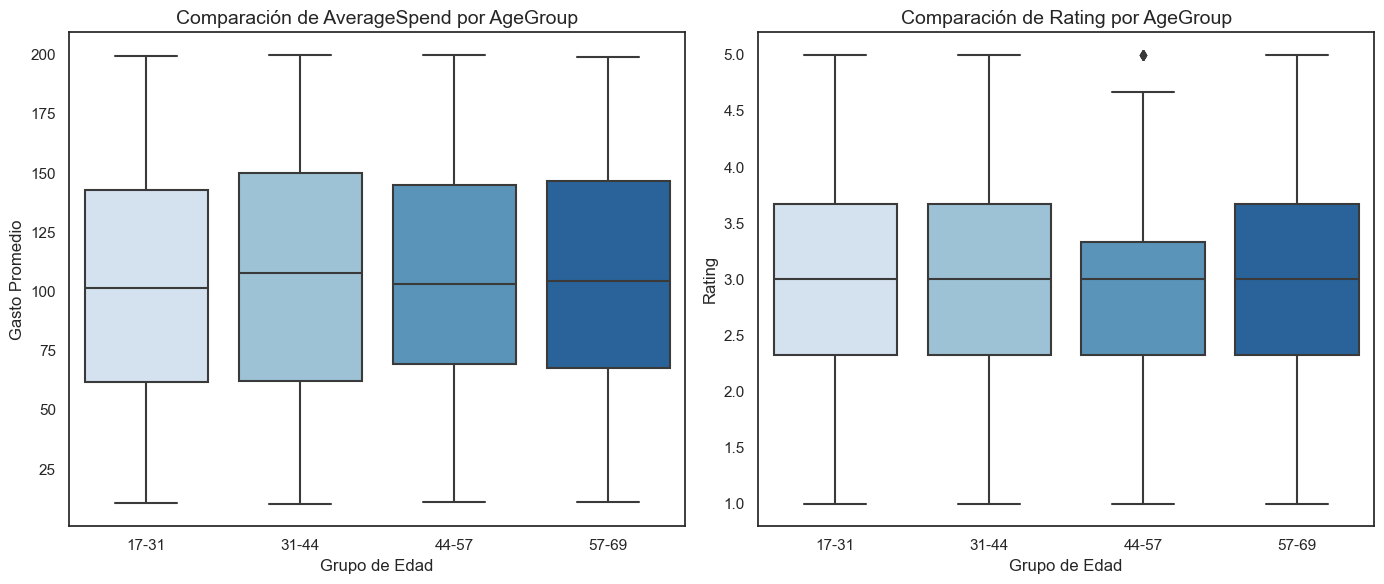

In [ ]:
plt.figure(figsize=(14, 6))

# Primera gráfica
plt.subplot(1, 2, 1)
sns.boxplot(x='AgeGroup', y='AverageSpend', data=df, palette='Blues')
plt.title('Comparación de AverageSpend por AgeGroup', fontsize=14)
plt.xlabel('Grupo de Edad', fontsize=12)
plt.ylabel('Gasto Promedio', fontsize=12)

# Segunda gráfica
plt.subplot(1, 2, 2)
sns.boxplot(x='AgeGroup', y='Rating', data=df, palette='Blues')
plt.title('Comparación de Rating por AgeGroup', fontsize=14)
plt.xlabel('Grupo de Edad', fontsize=12)
plt.ylabel('Rating', fontsize=12)

plt.tight_layout()
plt.show()


### Income

#### Intervalos

In [ ]:
# Volver a generar los rangos y etiquetas personalizadas
intervalos = pd.qcut(df['Income'], q=6)  # Crear intervalos nuevamente
nuevas_etiquetas = [f"{int(interval.left)}-{int(interval.right)}" for interval in intervalos.cat.categories]

# Reasignar las etiquetas directamente al DataFrame
df['IncomeGroup'] = pd.qcut(df['Income'], q=6, labels=nuevas_etiquetas)

#### Gráfica

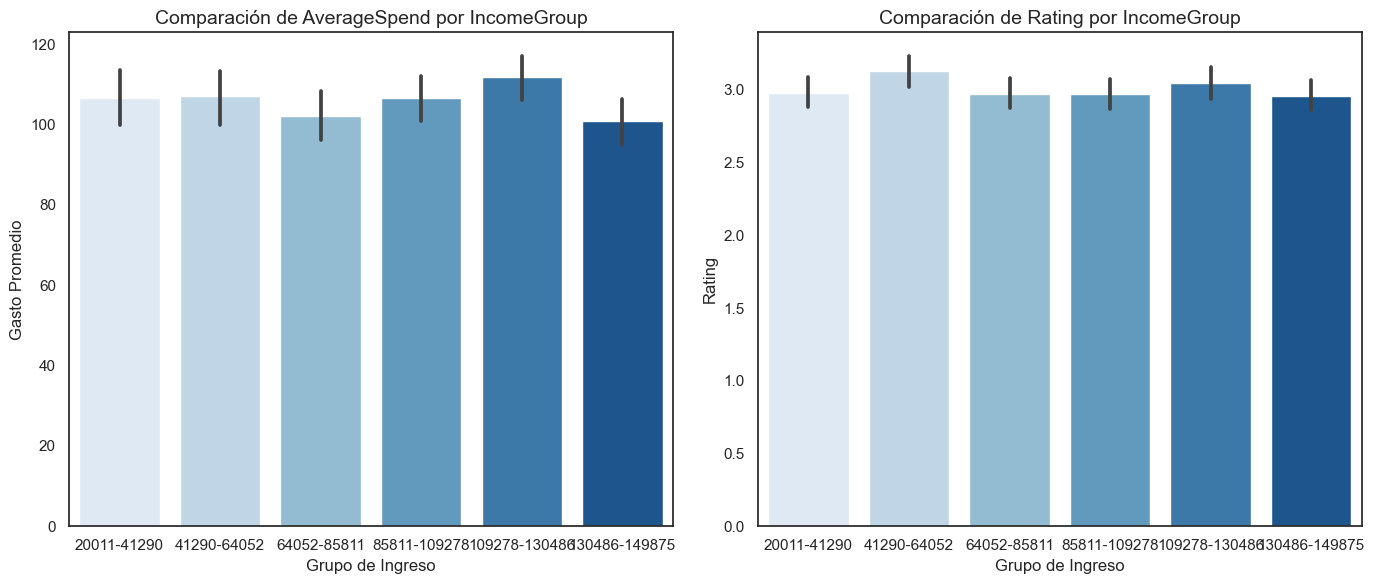

In [ ]:
plt.figure(figsize=(14, 6))

# Primera gráfica
plt.subplot(1, 2, 1)
sns.barplot(x='IncomeGroup', y='AverageSpend', data=df, palette='Blues')
plt.title('Comparación de AverageSpend por IncomeGroup', fontsize=14)
plt.xlabel('Grupo de Ingreso', fontsize=12)
plt.ylabel('Gasto Promedio', fontsize=12)

# Segunda gráfica
plt.subplot(1, 2, 2)
sns.barplot(x='IncomeGroup', y='Rating', data=df, palette='Blues')
plt.title('Comparación de Rating por IncomeGroup', fontsize=14)
plt.xlabel('Grupo de Ingreso', fontsize=12)
plt.ylabel('Rating', fontsize=12)

plt.tight_layout()
plt.show()


### Visit Frecuency

#### Gráfica

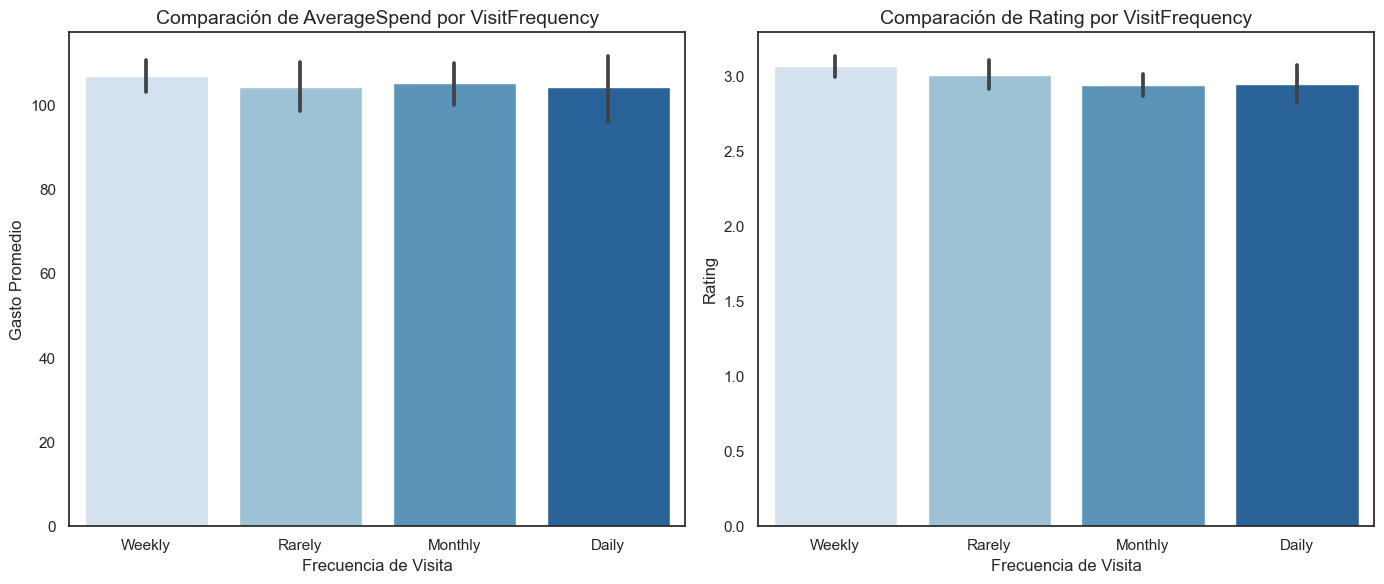

In [ ]:
plt.figure(figsize=(14, 6))

# Primera gráfica
plt.subplot(1, 2, 1)
sns.barplot(x='VisitFrequency', y='AverageSpend', data=df, palette='Blues')
plt.title('Comparación de AverageSpend por VisitFrequency', fontsize=14)
plt.xlabel('Frecuencia de Visita', fontsize=12)
plt.ylabel('Gasto Promedio', fontsize=12)

# Segunda gráfica:
plt.subplot(1, 2, 2)
sns.barplot(x='VisitFrequency', y='Rating', data=df, palette='Blues')
plt.title('Comparación de Rating por VisitFrequency', fontsize=14)
plt.xlabel('Frecuencia de Visita', fontsize=12)
plt.ylabel('Rating', fontsize=12)

plt.tight_layout()
plt.show()

### Preferred Cuisine

#### Gráfica

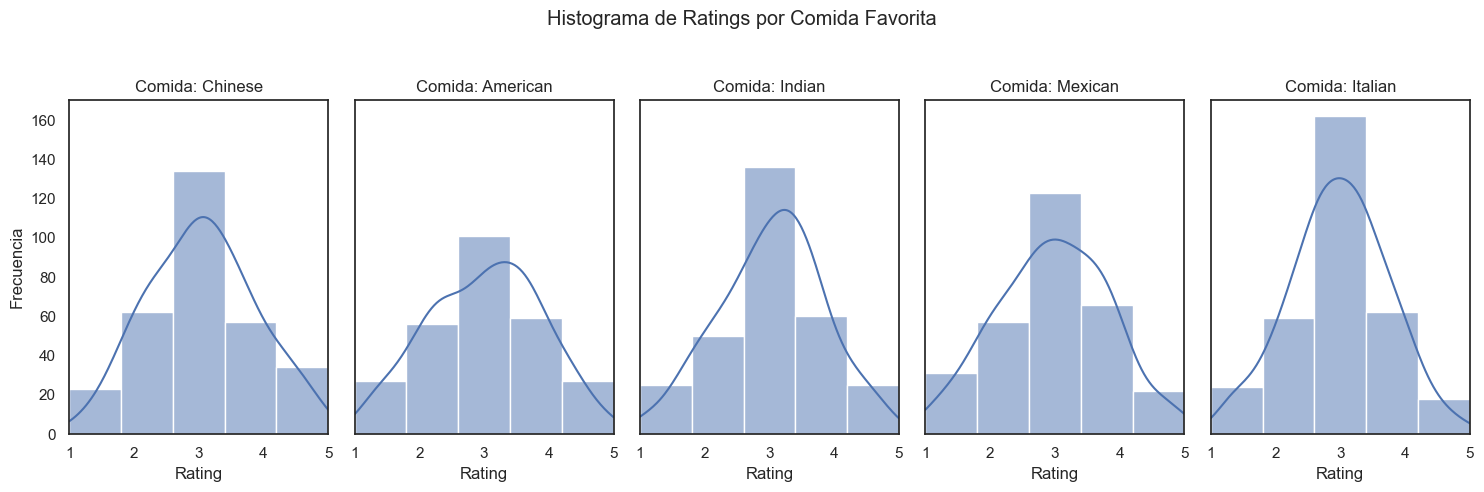

In [ ]:
df_foods = df['PreferredCuisine'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(df_foods), figsize=(15, 5), sharey=True)
for i, df_foods in enumerate(df_foods):
    # Filtra el DataFrame para la comida actual
    data_food = df[df['PreferredCuisine'] == df_foods]

    # Crea el histograma para esta comida, aplicando un color de la paleta 'Blues'
    sns.histplot(data_food['Rating'], bins=5, kde=True, ax=axes[i])

    # Etiqueta el subplot
    axes[i].set_title(f'Comida: {df_foods}')
    axes[i].set_xlabel('Rating')
    axes[i].set_xlim(1, 5)

# Etiqueta general para el eje Y
axes[0].set_ylabel('Frecuencia')
plt.suptitle('Histograma de Ratings por Comida Favorita')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Time of Visit

#### Gráfica

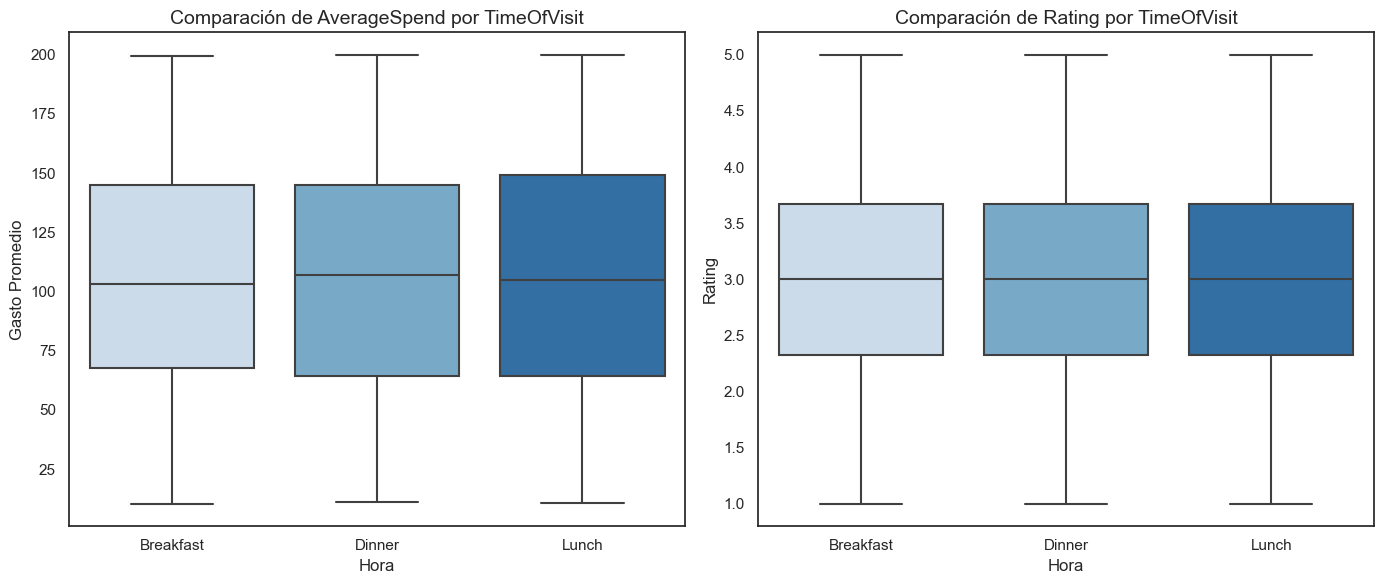

In [ ]:
plt.figure(figsize=(14, 6))

# Primera gráfica
plt.subplot(1, 2, 1)
sns.boxplot(x='TimeOfVisit', y='AverageSpend', data=df, palette='Blues')
plt.title('Comparación de AverageSpend por TimeOfVisit', fontsize=14)
plt.xlabel('Hora', fontsize=12)
plt.ylabel('Gasto Promedio', fontsize=12)

# Segunda gráfica:
plt.subplot(1, 2, 2)
sns.boxplot(x='TimeOfVisit', y='Rating', data=df, palette='Blues')
plt.title('Comparación de Rating por TimeOfVisit', fontsize=14)
plt.xlabel('Hora', fontsize=12)
plt.ylabel('Rating', fontsize=12)

plt.tight_layout()
plt.show()

### Group Size

#### Gráfica

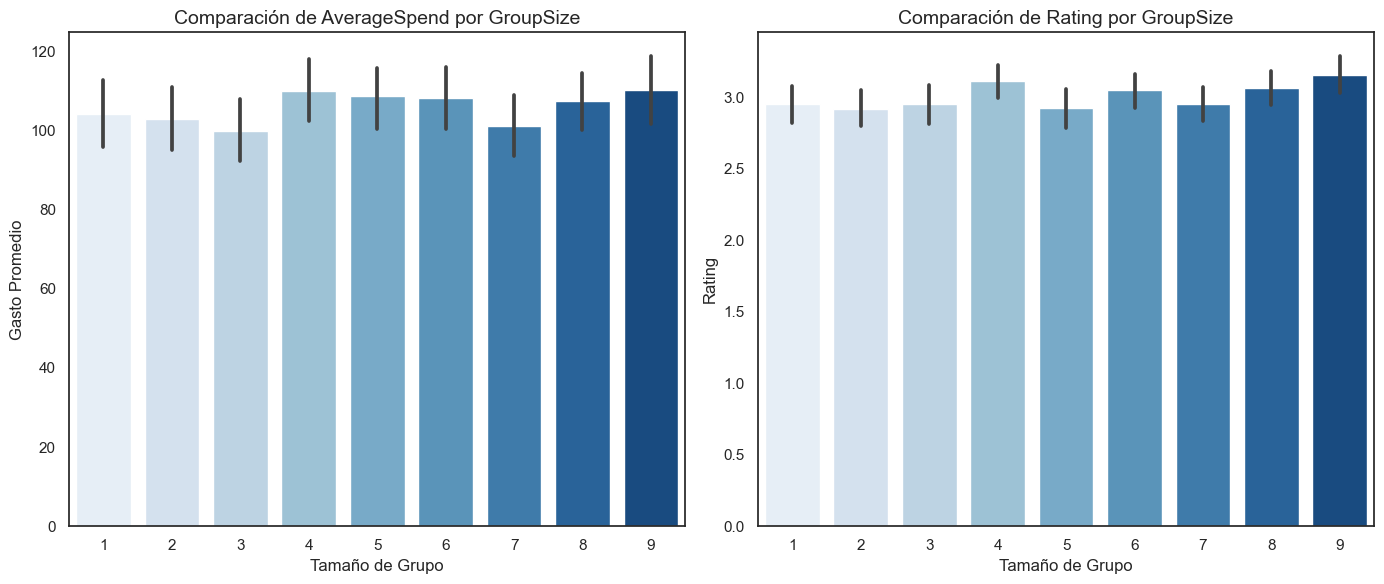

In [ ]:
plt.figure(figsize=(14, 6))

# Primera gráfica
plt.subplot(1, 2, 1)
sns.barplot(x='GroupSize', y='AverageSpend', data=df, palette='Blues')
plt.title('Comparación de AverageSpend por GroupSize', fontsize=14)
plt.xlabel('Tamaño de Grupo', fontsize=12)
plt.ylabel('Gasto Promedio', fontsize=12)

# Segunda gráfica:
plt.subplot(1, 2, 2)
sns.barplot(x='GroupSize', y='Rating', data=df, palette='Blues')
plt.title('Comparación de Rating por GroupSize', fontsize=14)
plt.xlabel('Tamaño de Grupo', fontsize=12)
plt.ylabel('Rating', fontsize=12)

plt.tight_layout()
plt.show()

### Dining Occasion

#### Gráfica

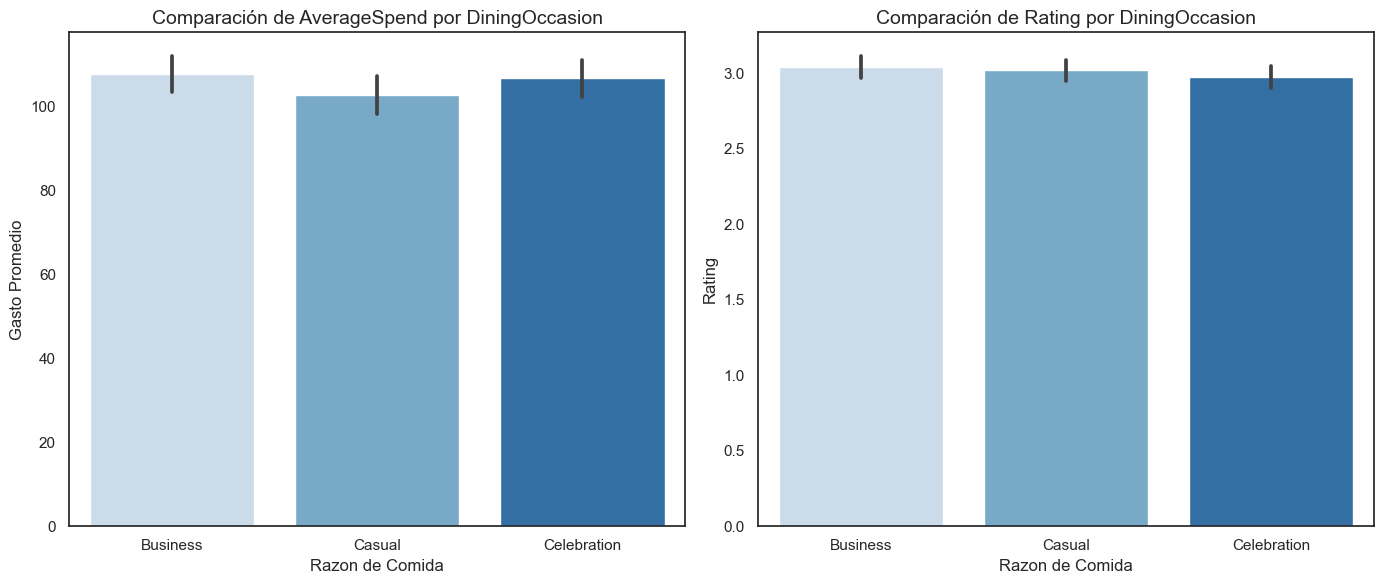

In [ ]:
plt.figure(figsize=(14, 6))

# Primera gráfica
plt.subplot(1, 2, 1)
sns.barplot(x='DiningOccasion', y='AverageSpend', data=df, palette='Blues')
plt.title('Comparación de AverageSpend por DiningOccasion', fontsize=14)
plt.xlabel('Razon de Comida', fontsize=12)
plt.ylabel('Gasto Promedio', fontsize=12)

# Segunda gráfica:
plt.subplot(1, 2, 2)
sns.barplot(x='DiningOccasion', y='Rating', data=df, palette='Blues')
plt.title('Comparación de Rating por DiningOccasion', fontsize=14)
plt.xlabel('Razon de Comida', fontsize=12)
plt.ylabel('Rating', fontsize=12)

plt.tight_layout()
plt.show()

### Wait Time

#### Intervalos

In [ ]:
# Volver a generar los rangos y etiquetas personalizadas
intervalos = pd.qcut(df['WaitTime'], q=6)  # Crear intervalos nuevamente
nuevas_etiquetas = [f"{int(interval.left)}-{int(interval.right)}" for interval in intervalos.cat.categories]

# Reasignar las etiquetas directamente al DataFrame
df['WaitTimeGroup'] = pd.qcut(df['WaitTime'], q=6, labels=nuevas_etiquetas)

#### Gráfica

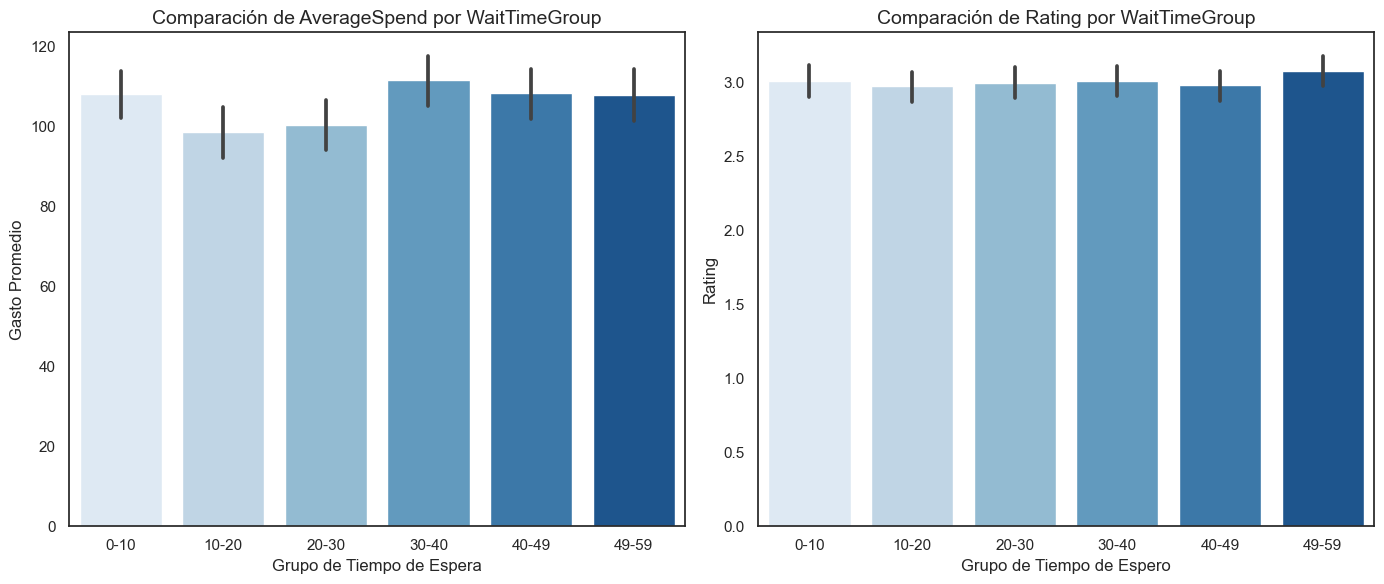

In [ ]:
plt.figure(figsize=(14, 6))

# Primera gráfica
plt.subplot(1, 2, 1)
sns.barplot(x='WaitTimeGroup', y='AverageSpend', data=df, palette='Blues')
plt.title('Comparación de AverageSpend por WaitTimeGroup', fontsize=14)
plt.xlabel('Grupo de Tiempo de Espera', fontsize=12)
plt.ylabel('Gasto Promedio', fontsize=12)

# Segunda gráfica
plt.subplot(1, 2, 2)
sns.barplot(x='WaitTimeGroup', y='Rating', data=df, palette='Blues')
plt.title('Comparación de Rating por WaitTimeGroup', fontsize=14)
plt.xlabel('Grupo de Tiempo de Espero', fontsize=12)
plt.ylabel('Rating', fontsize=12)

plt.tight_layout()
plt.show()


### AverageSpend vs Rating

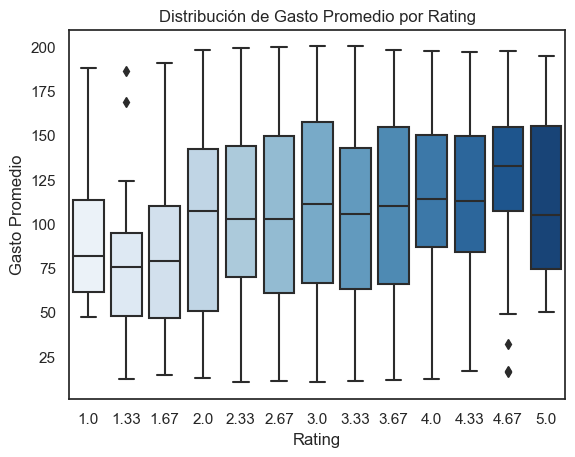

In [ ]:
sns.boxplot(x='Rating', y='AverageSpend', data=df, palette='Blues')
plt.title('Distribución de Gasto Promedio por Rating')
plt.xlabel('Rating')
plt.ylabel('Gasto Promedio')
plt.show()

## Clusters

### Creación Dummies

In [10]:
# Separar variables numéricas y categóricas
numerical_features = ['Age', 'Income','GroupSize','WaitTime','AverageSpend']
categorical_features = ['VisitFrequency', 'PreferredCuisine', 'Gender','TimeOfVisit', 'DiningOccasion',]

# Hacer las categóricas dummies
encoded_features = pd.get_dummies(df[categorical_features],
               columns=categorical_features,
               drop_first=True)

# Estandarizar variables numéricas
data_to_model_standarized = StandardScaler().fit_transform(df[numerical_features])

# Hacer dataframe variables numéricas
data_to_model_df = pd.DataFrame(data_to_model_standarized,
                                columns=numerical_features).reset_index()

# Acomodar variables categóricas
encoded_features_df = encoded_features.reset_index()

# Juntar ambas variables
data_to_model = data_to_model_df.merge(encoded_features_df, on='index')
data_to_model = data_to_model.drop('index', axis=1)

data_to_model

,Age,Income,GroupSize,WaitTime,AverageSpend,VisitFrequency_Monthly,VisitFrequency_Rarely,VisitFrequency_Weekly,PreferredCuisine_Chinese,PreferredCuisine_Indian,PreferredCuisine_Italian,PreferredCuisine_Mexican,Gender_Male,TimeOfVisit_Dinner,TimeOfVisit_Lunch,DiningOccasion_Casual,DiningOccasion_Celebration
0,-0.590289,-0.066593,-0.795670,0.776385,-1.532493,False,False,True,True,False,False,False,True,False,False,False,False
1,-1.659653,-1.108162,-1.577528,1.589960,0.188303,False,True,False,False,False,False,False,True,True,False,True,False
2,-0.189277,-0.057241,0.377116,1.076162,0.017070,False,False,True,False,False,False,False,False,True,False,False,True
3,-0.055607,0.284150,-1.577528,-1.313922,-1.224419,False,True,False,False,True,False,False,True,False,True,False,True
4,0.746416,-0.471175,-1.577528,0.443125,0.830333,True,False,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-0.322948,0.758053,-1.186599,-1.334070,-0.841143,True,False,False,False,False,False,False,True,False,True,False,False
1496,-0.456618,1.246626,-0.404742,0.447478,1.673392,False,False,True,False,False,True,False,False,False,True,True,False
1497,0.144899,0.870758,-0.404742,-1.524703,0.869708,True,False,False,False,False,False,False,True,False,True,True,False
1498,-1.325476,-1.518245,0.377116,-0.344919,1.778938,False,False,True,False,False,True,False,True,True,False,True,False


### Método del Codo

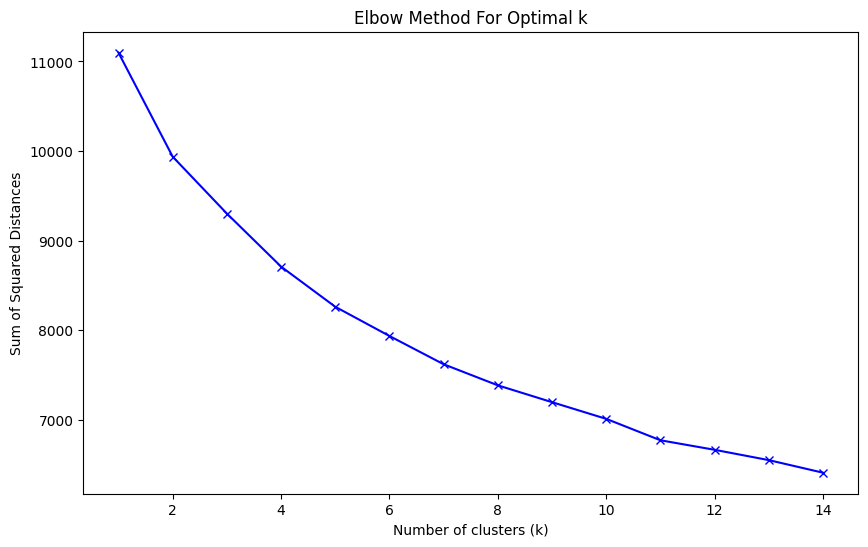

In [11]:
# Determinar el número óptimo de clusters usando el método del codo
sum_of_squared_distances = []
K = range(1, 15)  # Ajuste el rango según sea necesario
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(data_to_model)
    sum_of_squared_distances.append(km.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### Clusterización

In [12]:
# Aplicar K-means clustering para identificar segmentos de clientes
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(data_to_model)

# Agregar las etiquetas del cluster al DataFrame original para análisis
data_to_model['Cluster'] = labels
df['Cluster'] = labels
df.head()

,CustomerID,Age,Gender,Income,VisitFrequency,AverageSpend,PreferredCuisine,TimeOfVisit,GroupSize,DiningOccasion,MealType,WaitTime,ServiceRating,FoodRating,AmbianceRating,HighSatisfaction,Rating,Pro/Det,Cluster
0,654,35,Male,83380,Weekly,27.829142,Chinese,Breakfast,3,Business,Takeaway,43.523929,2,5,4,0,3.67,Pasivo,1
1,655,19,Male,43623,Rarely,115.408622,American,Dinner,1,Casual,Dine-in,57.524294,5,5,3,0,4.33,Detractor,4
2,656,41,Female,83737,Weekly,106.693771,American,Dinner,6,Celebration,Dine-in,48.682623,3,4,5,0,4.00,Promotor,4
3,657,43,Male,96768,Rarely,43.508508,Indian,Lunch,1,Celebration,Dine-in,7.552993,4,5,1,0,3.33,Detractor,1
4,658,55,Female,67937,Monthly,148.084627,Chinese,Breakfast,1,Business,Takeaway,37.789041,2,3,5,0,3.33,Promotor,2


### Clusters de Variables Numéricas

In [13]:
def boxplot_clusters(columns):
    for col in columns:
        plt.figure(figsize=(5, 5))
        sns.boxplot(x='Cluster', y=col, data=df, hue='Cluster', palette='Blues')
        plt.title(f'Boxplot de {col} por Clusters')
        plt.show()

#### Gráficas

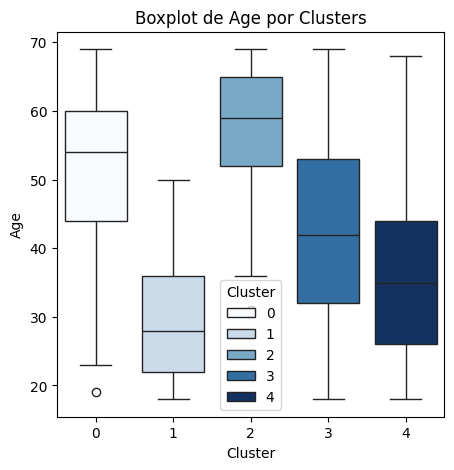

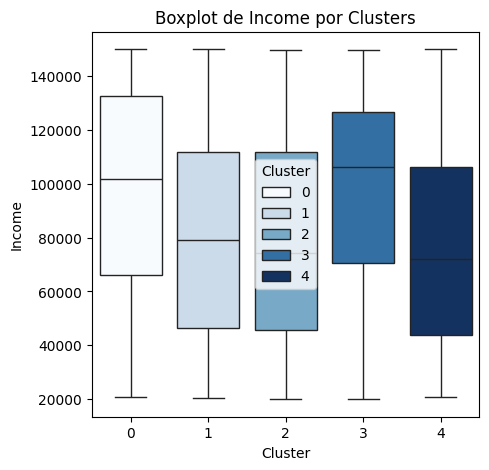

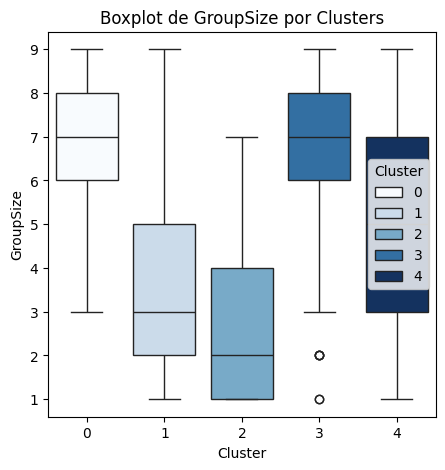

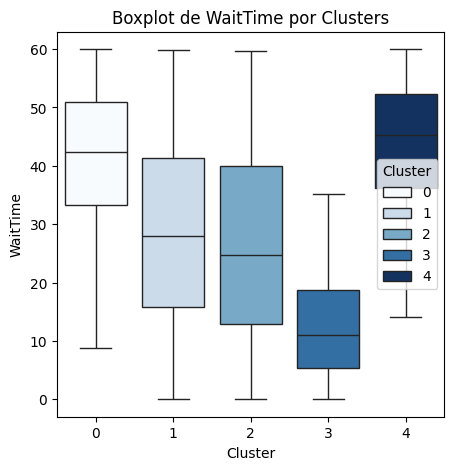

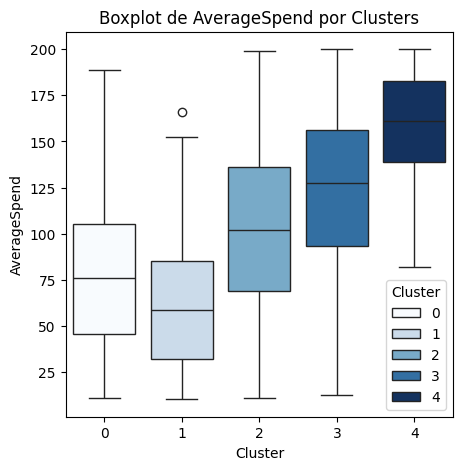

In [14]:
boxplot_clusters(numerical_features)

### Clusters de Variables Categóricas

In [15]:
def barplot_clusters(columns):
    for col in columns:
        sns.countplot(x='Cluster', hue=col, data=df, palette='Blues')
        plt.title('Count of Entries by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

#### Gráficas

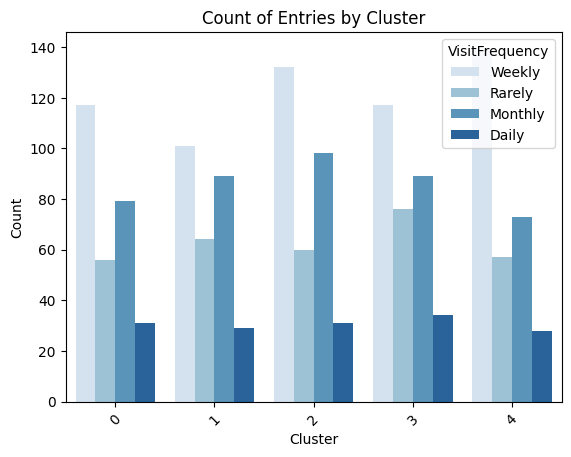

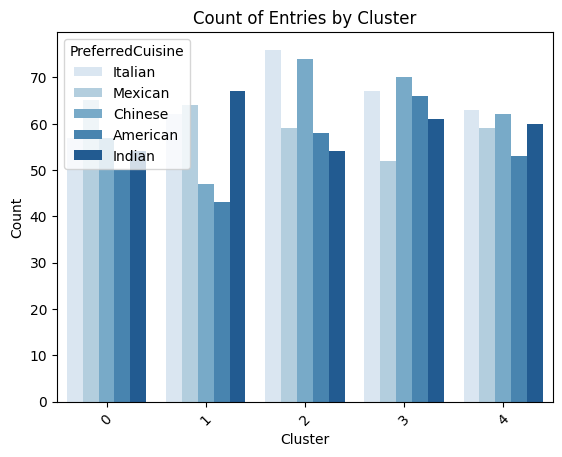

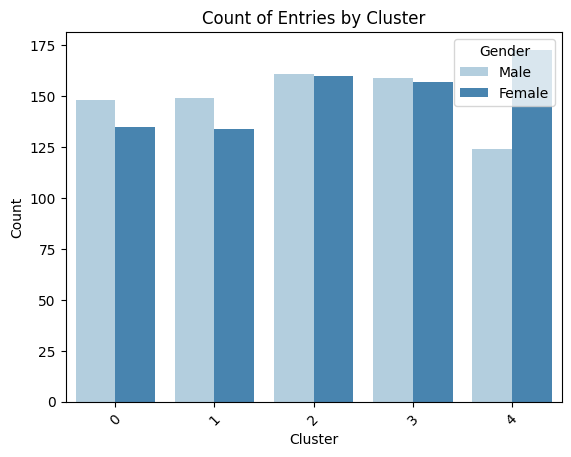

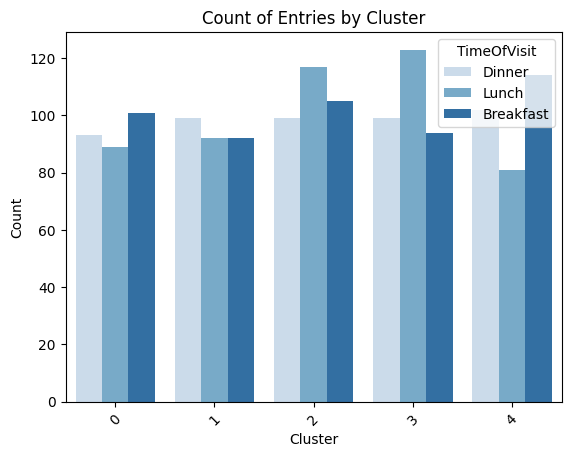

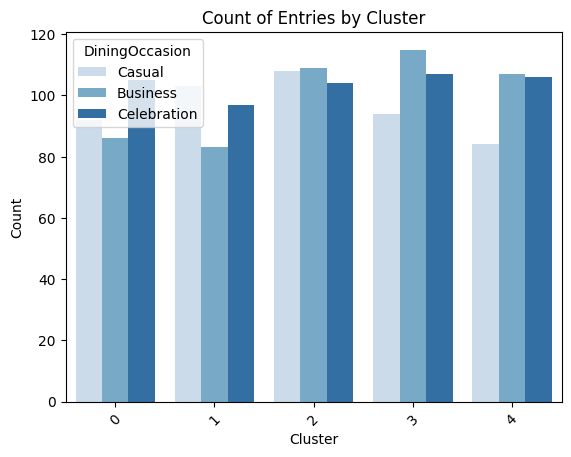

In [16]:
barplot_clusters(categorical_features)

### Conslusión

In [17]:
#### Pendiente me dió hueva

## Regresión Lineal

### Creación Regresión Lineal

In [25]:
categorical_features = ['VisitFrequency', 'PreferredCuisine', 'Gender','TimeOfVisit', 'DiningOccasion','Cluster']
numerical_features = ['Age', 'Income','GroupSize','WaitTime','AverageSpend']

data_encoded = pd.get_dummies(df[['CustomerID'] + categorical_features], columns=categorical_features)
df_reg = df[['CustomerID'] + numerical_features].merge(data_encoded, on = 'CustomerID')
df_reg['Rating']= df['Rating']

# Separar las columnas por tipo
numeric_cols = df_reg.select_dtypes(include=[np.number]).columns
boolean_cols = df_reg.select_dtypes(include=[bool]).columns

# Reordenar las columnas
ordered_cols = list(numeric_cols) + list(boolean_cols)
df_reg = df_reg[ordered_cols]

df_reg.head()

,CustomerID,Age,Income,GroupSize,WaitTime,AverageSpend,Rating,VisitFrequency_Daily,VisitFrequency_Monthly,VisitFrequency_Rarely,...,TimeOfVisit_Dinner,TimeOfVisit_Lunch,DiningOccasion_Business,DiningOccasion_Casual,DiningOccasion_Celebration,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,654,35,83380,3,43.523929,27.829142,3.67,False,False,False,...,False,False,True,False,False,False,True,False,False,False
1,655,19,43623,1,57.524294,115.408622,4.33,False,False,True,...,True,False,False,True,False,False,False,False,False,True
2,656,41,83737,6,48.682623,106.693771,4.00,False,False,False,...,True,False,False,False,True,False,False,False,False,True
3,657,43,96768,1,7.552993,43.508508,3.33,False,False,True,...,False,True,False,False,True,False,True,False,False,False
4,658,55,67937,1,37.789041,148.084627,3.33,False,True,False,...,False,False,True,False,False,False,False,True,False,False


In [26]:
dummies_columns = df_reg.loc[:, 'VisitFrequency_Daily':].select_dtypes(include='bool').columns
df_reg[dummies_columns] = df_reg[dummies_columns].astype(int)
df_reg.head()

,CustomerID,Age,Income,GroupSize,WaitTime,AverageSpend,Rating,VisitFrequency_Daily,VisitFrequency_Monthly,VisitFrequency_Rarely,...,TimeOfVisit_Dinner,TimeOfVisit_Lunch,DiningOccasion_Business,DiningOccasion_Casual,DiningOccasion_Celebration,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,654,35,83380,3,43.523929,27.829142,3.67,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,655,19,43623,1,57.524294,115.408622,4.33,0,0,1,...,1,0,0,1,0,0,0,0,0,1
2,656,41,83737,6,48.682623,106.693771,4.00,0,0,0,...,1,0,0,0,1,0,0,0,0,1
3,657,43,96768,1,7.552993,43.508508,3.33,0,0,1,...,0,1,0,0,1,0,1,0,0,0
4,658,55,67937,1,37.789041,148.084627,3.33,0,1,0,...,0,0,1,0,0,0,0,1,0,0


In [27]:
X = df_reg[['AverageSpend','GroupSize','Gender_Female','Gender_Male','VisitFrequency_Daily','VisitFrequency_Monthly','VisitFrequency_Rarely','VisitFrequency_Weekly','PreferredCuisine_American','PreferredCuisine_Italian','PreferredCuisine_Mexican','PreferredCuisine_Chinese','PreferredCuisine_Indian','TimeOfVisit_Breakfast','TimeOfVisit_Dinner','TimeOfVisit_Lunch','DiningOccasion_Business','DiningOccasion_Casual','DiningOccasion_Celebration']]
y = df_reg['Rating']

### Resultados Regresión

In [28]:
X = sm.add_constant(X)

# Ajustar el modelo usando OLS
model = sm.OLS(y, X)
results = model.fit()

# Mostrar el resumen del modelo
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.534
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           9.45e-06
Time:                        18:45:13   Log-Likelihood:                -1834.3
No. Observations:                1500   AIC:                             3699.
Df Residuals:                    1485   BIC:                             3778.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### Ecuación de la regresión

In [61]:
ecuacion = list(X.columns)

coeficientes = results.params

print("La ecuación de la regresión es:\ny = " + str(round(coeficientes.iloc[1], 4)) + "*" + str(ecuacion[1]) + " + " + str(round(coeficientes.iloc[2], 4)) + "*" + str(ecuacion[2]) +
      " + " + str(round(coeficientes.iloc[3], 4)) + "*" + str(ecuacion[3]) + " + " + str(round(coeficientes.iloc[4], 4)) + "*" + str(ecuacion[4]) +
      " + " + str(round(coeficientes.iloc[5], 4)) + "*" + str(ecuacion[5]) + " + " + str(round(coeficientes.iloc[6], 4)) + "*" + str(ecuacion[6]) +
      " + " + str(round(coeficientes.iloc[7], 4)) + "*" + str(ecuacion[7]) + "\n    + " + str(round(coeficientes.iloc[8], 4)) + "*" + str(ecuacion[8]) +
      " + " + str(round(coeficientes.iloc[9], 4)) + "*" + str(ecuacion[9]) + " + " + str(round(coeficientes.iloc[10], 4)) + "*" + str(ecuacion[10]) +
      " + " + str(round(coeficientes.iloc[11], 4)) + "*" + str(ecuacion[11]) + " + " + str(round(coeficientes.iloc[12], 4)) + "*" + str(ecuacion[12]) +
      "\n    + " + str(round(coeficientes.iloc[13], 4)) + "*" + str(ecuacion[13]) + " + " + str(round(coeficientes.iloc[14], 4)) + "*" + str(ecuacion[14]) +
      " + " + str(round(coeficientes.iloc[15], 4)) + "*" + str(ecuacion[15]) + " + " + str(round(coeficientes.iloc[16], 4)) + "*" + str(ecuacion[16]) +
      " + " + str(round(coeficientes.iloc[17], 4)) + "*" + str(ecuacion[17]) + "\n    + " + str(round(coeficientes.iloc[18], 4)) + "*" + str(ecuacion[18]) +
      "+ " + str(round(coeficientes.iloc[19], 4)) + "*" + str(ecuacion[19]) + " + " + str(round(coeficientes.iloc[0], 4))
      )

La ecuación de la regresión es:
y = 0.0024*AverageSpend + 0.0174*GroupSize + 0.4944*Gender_Female + 0.5203*Gender_Male + 0.208*VisitFrequency_Daily + 0.2038*VisitFrequency_Monthly + 0.2796*VisitFrequency_Rarely
    + 0.3232*VisitFrequency_Weekly + 0.2102*PreferredCuisine_American + 0.1731*PreferredCuisine_Italian + 0.1685*PreferredCuisine_Mexican + 0.2297*PreferredCuisine_Chinese
    + 0.2332*PreferredCuisine_Indian + 0.3406*TimeOfVisit_Breakfast + 0.3659*TimeOfVisit_Dinner + 0.3083*TimeOfVisit_Lunch + 0.3597*DiningOccasion_Business
    + 0.3537*DiningOccasion_Casual+ 0.3013*DiningOccasion_Celebration + 1.0147


$y = 0.0024*AverageSpend + 0.0174*GroupSize + 0.4944*Gender_Female + 0.5203*Gender_Male + 0.208*VisitFrequency_Daily + 0.2038*VisitFrequency_Monthly + 0.2796*VisitFrequency_Rarely + 0.3232*VisitFrequency_Weekly + 0.2102*PreferredCuisine_American + 0.1731*PreferredCuisine_Italian + 0.1685*PreferredCuisine_Mexican + 0.2297*PreferredCuisine_Chinese + 0.2332*PreferredCuisine_Indian + 0.3406*TimeOfVisit_Breakfast + 0.3659*TimeOfVisit_Dinner + 0.3083*TimeOfVisit_Lunch + 0.3597*DiningOccasion_Business + 0.3537*DiningOccasion_Casual+ 0.3013*DiningOccasion_Celebration + 1.0147$

## Forecast

<Axes: >

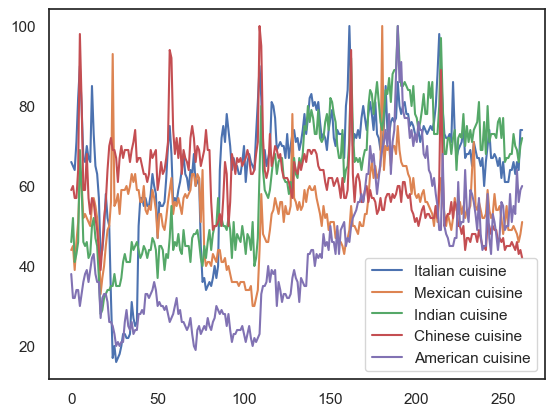

In [ ]:
df2=pd.read_csv('multiTimeline3.csv')
df2.plot()

#### Forecast

In [ ]:
df3 = pd.read_csv('Ita.csv', parse_dates=['Fecha'])
df3.set_index('Fecha', inplace=True)
df3

FileNotFoundError: [Errno 2] No such file or directory: 'Ita.csv'

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df3.index, df3['Ventas'], marker='o')
plt.title('Ventas Mensuales de ForecastTech Inc.')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.grid(True)
plt.show()

In [ ]:
model = auto_timeseries(
    score_type='rmse',       # Métrica de evaluación
    time_interval='W',       # Intervalo mensual
    non_seasonal_pdq=None,   # Para modelos SARIMAX
    seasonality=True,       # Deshabilitar búsqueda de estacionalidad (se puede cambiar)
    model_type='best',       # Seleccionar el mejor modelo
    verbose=2                # Nivel de verbosidad
)

In [ ]:
train_size = int(0.8 * len(df3))
train_df = df3[:train_size]
test_df = df3[train_size:]

model.fit(
    traindata=train_df,
    ts_column=train_df.index.name,
    target='Ventas'
)

In [ ]:
forecast = model.predict(testdata=test_df)
forecast.head()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_df.index, train_df['Ventas'], label='Entrenamiento')
plt.plot(test_df.index, test_df['Ventas'], label='Datos Reales')
plt.plot(test_df.index, forecast['yhat'], label='Predicción', linestyle='--')
plt.title('Predicción de Ventas Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
future_periods = 24
last_date = df3.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_periods, freq='W')

future_df = pd.DataFrame(index=future_dates)
future_forecast = model.predict(testdata=future_df)

plt.figure(figsize=(12,6))
plt.plot(df3.index, df3['Ventas'], label='Histórico')
plt.plot(future_dates, future_forecast['yhat'], label='Predicción Futura', linestyle='--')
plt.title('Predicción de Ventas Mensuales Futuras')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()

## SEM

### Módelo

In [18]:
model_desc = """
# Latent Variables
Satisfaccion_cliente =~ ServiceRating + FoodRating + AmbianceRating + WaitTime
Frecuencia_visita =~ VisitFrequency + AverageSpend + DiningOccasion

# Regressions
NPS ~ Satisfaccion_cliente + Frecuencia_visita

# Variances and Covariances
Satisfaccion_cliente ~~ Frecuencia_visita
"""

np.random.seed(42)

# Normalizar valores con MinMaxScaler
scaler = StandardScaler()

# 1. Variables relacionadas con Satisfaccion_cliente
ServiceRating = scaler.fit_transform(df['ServiceRating'].values.reshape(-1, 1))

FoodRating = scaler.fit_transform(df['FoodRating'].values.reshape(-1, 1))

AmbianceRating = scaler.fit_transform(df['AmbianceRating'].values.reshape(-1, 1))

WaitTime = scaler.fit_transform(df['WaitTime'].values.reshape(-1, 1))

# 2. Variables relacionadas con Frecuencia_visita
# Transformar la columna 'VisitFrequency' en valores numéricos
df['VisitFrequency_numeric'] = df['VisitFrequency'].apply(lambda x: 1 if x == 'Daily' else (2 if x == 'Weekly' else (3 if x == 'Monthly' else 4)))
VisitFrequency = scaler.fit_transform(df['VisitFrequency_numeric'].values.reshape(-1, 1))

AverageSpend = scaler.fit_transform(df['AverageSpend'].values.reshape(-1, 1))

# Transformar la columna 'DiningOccasion' en valores numéricos
df['DiningOccasion_numeric'] = df['DiningOccasion'].apply(lambda x: 1 if x == 'Casual' else (2 if x == 'Business' else 3))
DiningOccasion = scaler.fit_transform(df['DiningOccasion_numeric'].values.reshape(-1, 1))

# 3. Crear la variable NPS influenciada por Satisfaccion_cliente y Experiencia_compra
NPS = scaler.fit_transform(((ServiceRating + FoodRating + AmbianceRating + WaitTime)*0.6 + (VisitFrequency + AverageSpend + DiningOccasion)*0.4).flatten().reshape(-1, 1))

# 4. Crear DataFrame final con todas las variables relevantes
data_sem = pd.DataFrame({
    "ServiceRating": ServiceRating.flatten(),
    "FoodRating": FoodRating.flatten(),
    "AmbianceRating": AmbianceRating.flatten(),
    "WaitTime": WaitTime.flatten(),
    "VisitFrequency": VisitFrequency.flatten(),
    "AverageSpend": AverageSpend.flatten(),
    "DiningOccasion": DiningOccasion.flatten(),
    "NPS": NPS.flatten()  # Convertir NPS a una lista unidimensional
})

# Ajustar el modelo SEM a los datos generados
mod = Model(model_desc)
res_opt = mod.fit(data_sem)
estimates = mod.inspect()

# Imprimir los resultados del ajuste del modelo
print(estimates)

                    lval  op                  rval  Estimate  Std. Err  \
0          ServiceRating   ~  Satisfaccion_cliente  1.000000         -   
1             FoodRating   ~  Satisfaccion_cliente  0.980176  0.071298   
2         AmbianceRating   ~  Satisfaccion_cliente  0.960522  0.070781   
3               WaitTime   ~  Satisfaccion_cliente  0.979714  0.071277   
4         VisitFrequency   ~     Frecuencia_visita  1.000000         -   
5           AverageSpend   ~     Frecuencia_visita  1.493667  0.160276   
6         DiningOccasion   ~     Frecuencia_visita  1.040719  0.130628   
7                    NPS   ~  Satisfaccion_cliente  1.630735  0.260044   
8                    NPS   ~     Frecuencia_visita  0.985031  0.409157   
9   Satisfaccion_cliente  ~~     Frecuencia_visita  0.109557  0.013729   
10  Satisfaccion_cliente  ~~  Satisfaccion_cliente  0.210425  0.024266   
11     Frecuencia_visita  ~~     Frecuencia_visita  0.091267  0.018801   
12        AmbianceRating  ~~        Am

In [19]:
print(res_opt)

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 2.793
Number of iterations: 29
Params: 0.980 0.961 0.980 1.494 1.041 1.631 0.985 0.110 0.210 0.806 0.797 0.901 0.798 0.091 0.000 0.790 0.909 0.798


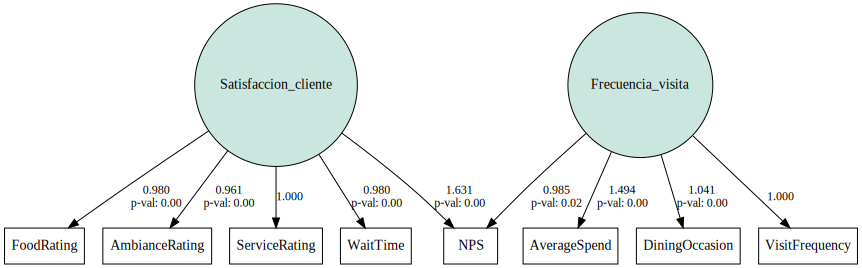

In [21]:
g = semplot(mod, "pd.png")
g

### Conclusión

#### Análisis del Modelo SEM y Resultados

Este análisis está basado en un modelo de ecuaciones estructurales (SEM) que mide la influencia de dos variables latentes (**Satisfacción del cliente** y **Frecuencia de visita**) sobre el **NPS**. A continuación, se presenta un resumen de los resultados y las conclusiones derivadas del modelo.

#### Estimaciones de Parámetros

1. **Relaciones entre Variables Latentes y Observadas**:
   - **ServiceRating** (Satisfaccion_cliente): Establecido como referencia con un valor de 1.0 (por convención en SEM).
   - **FoodRating** (Satisfaccion_cliente): Estima una carga factorial de **0.980**, lo que indica una fuerte relación con la variable latente **Satisfacción del cliente**.
   - **AmbianceRating** (Satisfaccion_cliente): Tiene una carga factorial de **0.961**, también indicando una relación fuerte con **Satisfacción del cliente**, aunque un poco menor que **AmbianceRating**.
   - **WaitTime** (Satisfaccion_cliente): Estima una carga factorial de **0.980**, lo que indica una relación igual de fuerte con la variable latente **Satisfacción del cliente**, que **ServiceRating**.
   - **VisitFrequency** (Frecuencia_visita): Establecido como referencia con un valor de 1.0 (por convención en SEM).
   - **DiningOccasion** (Frecuencia_visita): Carga factorial de **1.041**, lo que indica una relación fuerte con la **Frecuencia de visita**.
   - **AverageSpend** (Frecuencia_visita): Carga factorial de **1.494**, lo que indica una relación fuerte con la variable latente **Frecuencia de visita**, mayor a la relación de **DiningOccasion**

2. **Relaciones entre las Variables Latentes y el NPS**:
   - **Satisfaccion_cliente** → **NPS**: Coeficiente de **1.631**, con una significancia muy alta (*p-value = 0.00*). Esto indica que, a mayor satisfacción del cliente, mayor es el NPS.
   - **Frecuencia_visita** → **NPS**: Coeficiente de **0.985**, significativo (*p-value = 0.00*), sugiriendo que la frecuencia de visita tiene una influencia importante sobre el NPS, aunque menor que la de la satisfacción del cliente.

3. **Covarianzas**:
   - **Satisfaccion_cliente** y **Frecuencia_visita** están poco correlacionadas (**0.1096**). Esta relación es estadísticamente significativa (*p-value = 0.00*).
   - La varianza residual de **NPS** es exactamente **0.00**, lo que indica que el modelo si captura la varianza en NPS, lo que dice, que están explicados todos los factores que influyen.

#### Métricas de Ajuste del Modelo

El ajuste del modelo  fue satisfactorio, con un valor objetivo de **2.793** después de 29 iteraciones utilizando el método de optimización **SLSQP**. El modelo se ajustó correctamente a los datos, lo que se refleja en el éxito del proceso de optimización.

#### Interpretación General

- **Satisfacción del cliente** y **Frecuencia de visita** son dos factores clave que explican el **NPS** en la empresa. Ambos factores tienen un impacto positivo, siendo la **Satisfaccion del cliente** el factor más importante en términos de influencia sobre el NPS.

- Las relaciones entre las variables latentes y sus indicadores observados son fuertes y significativas, lo que valida la construcción teórica de las variables latentes de **Satisfacción del cliente** y **Frecuencia de visita**.

#### Conclusiones

Este modelo de ecuaciones estructurales ha demostrado ser útil para entender cómo factores complejos como la **Satisfacción del cliente** y **Frecuencia de visita** impactan en el NPS. La empresa pueden enfocarse en mejorar estos dos aspectos, para aumentar su NPS. Además, las intervenciones en mejorar su enfoque por Ratings pueden ser prioritarias, dado su peso en los constructos latentes.

Este análisis proporciona una base sólida para la toma de decisiones basada en datos dentro de la empresa, dirigiendo los esfuerzos hacia las áreas que mayor impacto tienen en el NPS.

# AB Testing (propuestas)

El objetivo de nuestra propuesta de AB Testing es poder evaluar el impacto que tiene en los clientes el introducir nuevos platillos de cierto tipo de cocina en la carta. Analizaremos si este cambio influye en la percepción de los clientes sobre su experiencia tanto con la comida como con el lugar.

Para esta prueba usaremos la cocina que tiene mayor preferencia entre los clientes, la cual es la cocina italiana. Para esta prueba usaremos dos grupos:

* Grupo A: Clientes donde se les dará la carta normal sin incluir platillos nuevos.

* Grupo B: Cientes que se les ofrecerá la carta nueva con 3 platillos nuevos en la sección de cocina italiana.

Con nuestra propuesta mediremos los siguientes aspectos claves

* Interes de los Clientes: Calcularemos el porcentaje de personas del Grupo B que pidieron los nuevos platillos.
* Impacto en la satisfacción: A través de encuestas podremos medir si es que la satisfacción de los clientes aumenta con este cambio en el menú, si les parecio agradable la idea de innovar con platillos y fue una mejor experiencia, lo cual nos llevaría a una mejorá en el rating general del cliente y un aumento en el NPS.

Esta prube anos permitirá conocer si en realidad cambios en el menú tiene un impacto en la satifacción de los clientes para así tener una mejor toma de decisiones en el futuro.

Para nuestra propuesta tenemos la siguiente hipotesis

* Hipótesis
$$H_0: \Delta \leq 10\%$$
$$H_1: \Delta > 10\%$$

Para esto sacaremos el tamaño de muestra necesario para poder llevar a cabo nuestra propuesta:

&nbsp;Donde $\Delta$ el la diferencia de satisfacción promedio de los clientes.

Suponiendo que la tasa de conversión fue del 25\%, la muestra necesaria para realizar la prueba es:
$$
n = \frac{2 \times (Z_{\alpha/2} + Z_{\beta})^2 \times p(1-p)}{(p_1 - p_2)^2}
$$

In [ ]:
n1 = (2*((1.96+0.84)**2)*0.25*(1-0.25))/(0.21-0.30)**2
n1

362.96296296296293

Como resultado obtenemos que se debe aplicar a un grupo de 363 personas la propuesta ára poder determinar si el cambio es significativo o no.

# Recomendación de uso de AI

* **Uso de Chatbots para reservas y atención al cliente:** El chatbot se pondría en uso por medio de redes de comunicación como podría ser WhatsApp o Instagram, donde los clientes podrán hacer preguntas, realizar reservaciones o pedir solicitudes especiales. Este uso de AI permitirá que los clientes reciban respuestas rápidas mejorando la experiencia del cliente incluso fuera del restaurante.


* **Encuestas automatizadas:** Por medio de AI, al finalizar la visita, al cliente se le proprocionará un QR, que al escanearlo, abrirá una encuesta de satisfacción que será impulsada por AI para que las preguntas se vayan adaptando a la información que el cliente vaya proporcionando. Esto mejoraría la recopilación de datos y ayudaría a que el restaurante entienda a profundidad las opiniones de sus clientes para saber con exactitud cuales son sus áreas de mejora.